<a href="https://colab.research.google.com/github/joshuabdixon/Bayesian-A-B-Testing-for-E-commerce-Advertising-Campaigns/blob/main/Bayesian_A_B_Testing_for_E_commerce_Advertising_Campaigns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian A/B Testing for E-commerce Advertising Campaigns

## Project Overview
This project applies Bayesian methodologies to compare two e-commerce advertising campaigns, aiming to identify which one generates the highest return on investment.

## Summary, Rationale and Approach
In this analysis, Bayesian methodologies were applied to determine which of two e-commerce advertising campaigns resulted in higher conversion rates. The process began with exploratory data analysis to understand key metrics and distributions. Subsequently, a Bayesian model was formulated using prior knowledge from the data analysis to evaluate the conversion rates of the two campaigns. Priors were set based on observed conversion rates and modeled using a Beta distribution to encapsulate our beliefs about the conversion efficiencies. The posterior distributions were then derived using PyMC, which allowed us to assess the likelihood of one campaign outperforming the other.

## Recommendations
Based on the analysis, it is recommended that the marketing team allocate more resources to the control campaign, as it has shown a higher efficacy in converting users. The statistical analysis supports this decision, indicating a 75% probability that the control campaign performs better than the variant in terms of conversion rates. However, it's important to note that the difference in conversion rates between the campaigns is relatively small.

To further refine our strategy and ensure the most efficient allocation of marketing budgets, additional data should be collected, particularly concerning the costs associated with each campaign. This will enable a more comprehensive analysis of the Return on Investment (ROI) for each campaign, ensuring that financial resources are optimised for maximum effectiveness in future campaigns.

Additionally, continuous monitoring and re-evaluation of the campaigns should be implemented. This will help in quickly identifying any changes in campaign performance and allow for timely adjustments to our marketing strategies.

# Bayesian A/B Testing

## Python Code - Structure
The code used to carry out the analysis has been structured as follows

0. Import Libraries, Data Preparation and Cleaning

1. Exploratory Data Analysis

2. Bayesian Model Set-Up

3. Bayesian Linear Regression

4. Results and Discussion

## 0. Import Libraries, Data Preparation and Cleaning

In [ ]:
# Import libraries
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import arviz as az

# Load the data set
data = pd.read_csv('https://raw.githubusercontent.com/fourthrevlxd/cam_dsb/main/AB_Test_Results.csv')
data.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [ ]:
# Import the warnings library.
import warnings
from numba import NumbaDeprecationWarning

# Specify which warnings to ignore.
warnings.filterwarnings('ignore', category=NumbaDeprecationWarning)

In [ ]:
# Remove unnecessary columns
data = data.drop("USER_ID", axis = 1)

In [ ]:
# Find the unique VARIANT_NAME values
unique_variants = data['VARIANT_NAME'].unique()

print(unique_variants, "\n")
print(data.info(), "\n")


['variant' 'control'] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   VARIANT_NAME  10000 non-null  object 
 1   REVENUE       10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB
None 



# 1.0 Exploratory Data Analysis

In [ ]:
# Create the 'CONVERGE' column based on tha revenue > 0. The boolean will asume 1 and 0 for values TRUE or FALSE`
data['CONVERSION'] = (data['REVENUE'] > 0).astype(int)

print(data.head(5), "\n")
print(data.info(), "\n")
print(data.describe(),"\n")

# Let's compare the number of conversion
control_CONV = data[data['VARIANT_NAME']=='control']['CONVERSION']
variant_CONV = data[data['VARIANT_NAME']=='variant']['CONVERSION']

print(f"The total number of conversions of the control data is {control_CONV.sum()}")
print(f"The total number of conversions of the variant data is {variant_CONV.sum()}","\n")

# Let's compare the revenues of either variant
control_REV = data[data['VARIANT_NAME']=='control']['REVENUE']
variant_REV = data[data['VARIANT_NAME']=='variant']['REVENUE']

print(f"The total revenue of the control data is £{control_REV.sum()}")
print(f"The total revenue of the variant data is £{variant_REV.sum()}","\n")

  VARIANT_NAME  REVENUE  CONVERSION
0      variant      0.0           0
1      control      0.0           0
2      control      0.0           0
3      control      0.0           0
4      variant      0.0           0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   VARIANT_NAME  10000 non-null  object 
 1   REVENUE       10000 non-null  float64
 2   CONVERSION    10000 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB
None 

            REVENUE    CONVERSION
count  10000.000000  10000.000000
mean       0.099447      0.015200
std        2.318529      0.122354
min        0.000000      0.000000
25%        0.000000      0.000000
50%        0.000000      0.000000
75%        0.000000      0.000000
max      196.010000      1.000000 

The total number of conversions of the control data is 80
The total number of con

## Histogram Plot

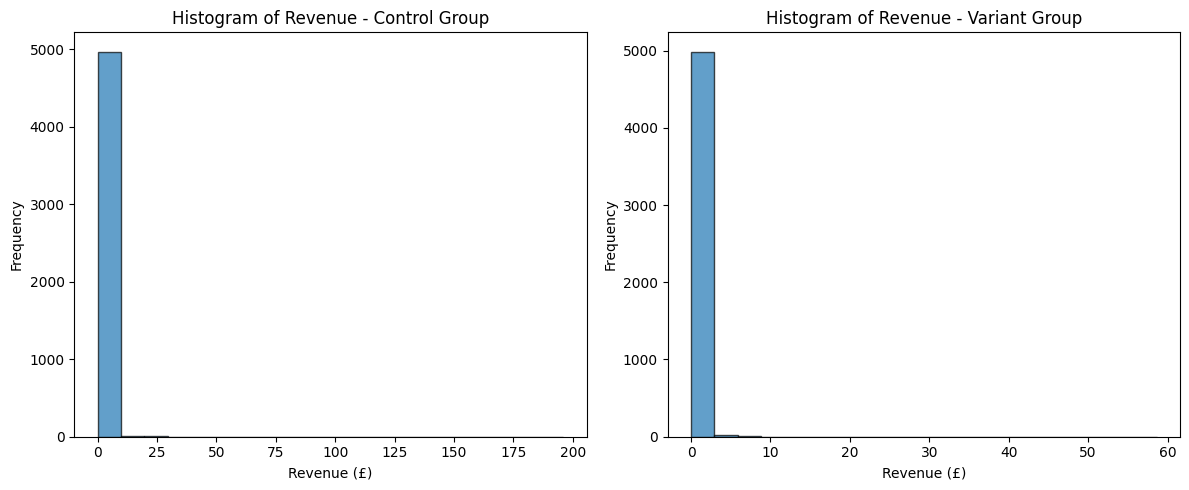

In [ ]:
# Histogram for revenue of both variants
plt.figure(figsize=(12, 5))

# Histogram for control group revenue
plt.subplot(1, 2, 1)
plt.hist(control_REV, bins=20, edgecolor='black', alpha=0.7)
plt.title('Histogram of Revenue - Control Group')
plt.xlabel('Revenue (£)')
plt.ylabel('Frequency')

# Histogram for variant group revenue
plt.subplot(1, 2, 2)
plt.hist(variant_REV, bins=20, edgecolor='black', alpha=0.7)
plt.title('Histogram of Revenue - Variant Group')
plt.xlabel('Revenue (£)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


**Interpretation:** It is noted that the data is skewed. This means Revenue may be an unnreliable metric for the analysis

## Bar Plot

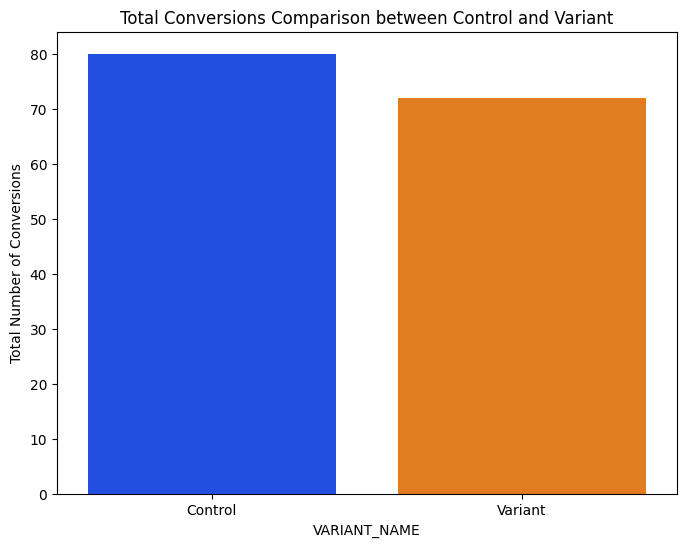

In [ ]:
# Bar plot for conversions of both variants
total_conversions_control = control_CONV.sum()
total_conversions_variant = variant_CONV.sum()

# Data preparation for plotting
conversions = [total_conversions_control, total_conversions_variant]
variants = ['Control', 'Variant']

# Creating the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=variants, y=conversions, palette='bright', hue = variants, legend = False)
plt.title('Total Conversions Comparison between Control and Variant')
plt.ylabel('Total Number of Conversions')
plt.xlabel('VARIANT_NAME')
plt.show()


Interpretation:
The dataset provides initial insights into the performance of two advertising campaigns labeled as 'control' and 'variant'. From the analysis, the control group achieved a total of 80 conversions, while the variant group had 72 conversions. The total revenue generated by the control group was £643, compared to £351.47 for the variant group. While the control group shows a higher total revenue, the number of conversions between the groups is relatively close.


## 2.0 Bayesian Model Set-Up



Given the observed data, the 'control' group has demonstrated higher total conversions and revenue, which we will use as prior knowledge to inform our posterior distribution.

The average revenue per conversion is also a significant consideration. Initial data suggests the control group not only had more conversions but possibly more profitable ones on average.

Our primary objective is to determine which campaign will generate the highest return on investment. Ideally, this would include an analysis of the total costs associated with each campaign. However, since cost data is unavailable, we will focus on the relative efficiency of the campaigns using either of the following metrics:

- Average Revenue per Conversion = Total Revenue / Number of Conversions: This ratio directly measures the value generated per successful transaction. However, the presence of many non-conversions (zero values) may skew this metric.

- Conversion Rate = (Number of Conversions / Total Customers) × 100%: This ratio is a straightforward indicator of a campaign's effectiveness at converting potential customers into actual customers. Unlike the average revenue per conversion, it is less affected by the monetary value of each transaction, making it a cleaner measure of campaign impact.
Due to its simplicity and fewer complications associated with zero revenue values, the Conversion Rate will be the primary focus of our Bayesian A/B testing.

**Conversion Rate** will be the focus of the Bayesian A/B test due to it's simplicity and potential complications associated with Average Revenue per Conversion.

### Bayesian Model Setup for Conversion Rates

**Bayes Rule:**

`P(lambda | data) = [P(data |lambda) x P(lambda)] / P(data)`

`Posterior Distribution = [Likelihood x Prior] / Evidence`

**Variables:**
- **lambda_control:** Conversion rate for the control group.
- **lambda_variant:** Conversion rate for the variant group.

**Bayesian Model Components:**
- **Priors:** Initial beliefs about conversion rates, potentially informed by our Exploratory Data Analysis
  - **Control:** `P(lambda_control)`
  - **Variant:** `P(lambda_variant)`

- **Likelihoods:** Probability of observing the actual conversion data given the conversion rates.
  - **Control Data Likelihood:** `P(data_control |lambda_control)`
  - **Variant Data Likelihood:** `P(data_variant |lambda_variant)`

- **Posterior Distributions:** Updated beliefs about the conversion rates after observing the data.
  - **Posterior for Control:** `P(λ_control | data_control)`
  - **Posterior for Variant:** `P(λ_variant | data_variant)`

- **Marginal Likelihood/Evidence:** The probability of observing the data under all possible conversion rates. This will be computed using PyMC. It can also be obtained by intergrating the nominator, but this is difficult.
  - **Evidence for Control:** `P(data_control)`
  - **Evidence for Variant:** `P(data_variant)`

**Hypotheses:**
- **Null Hypothesis (H0):** `lambda_control = lambda_variant` (The conversion rates are equal.)
- **Alternative Hypothesis (H1):** `lambda_control > lambda_variant` (The control campaign is more effective than the variant campaign.)





# 3.0 Bayesian Linear Regression

In [ ]:
# Create a Bayesian Linear Regression using PyMC

with pm.Model() as model:
    # Priors for probability of conversion
    # We will assume a beta distribution to calculate our priors
    # We will set up the prior slightly skewed in favour of the control group, given the results from our EDA
    lambda_control = pm.Beta('lambda_control', alpha=1.1, beta = 1.0) # Higher alpha skews towards 1
    lambda_variant = pm.Beta('lambda_variant', alpha=1.0, beta = 1.1) # Higher beta skews towards 0

    # Real data from the A/B testing
    data_control_true = control_CONV
    data_variant_true = variant_CONV

    # Likelihoods
    obs_control = pm.Bernoulli('obs_control', p=lambda_control, observed=data_control_true)
    obs_variant = pm.Bernoulli('obs_variant', p=lambda_variant, observed=data_variant_true)

    # Calculate the difference between probabilities of conversions
    diff = pm.Deterministic('diff', lambda_control - lambda_variant)

    # Return boolean  for where control has more conversions than variant
    control_more_conv = pm.Deterministic('control_more_conv', diff > 0)

    # Sampling
    trace = pm.sample(3000, return_inferencedata=True)

    # Probability of control having more conversions than variant
    prob_control_more_conv = trace.posterior['control_more_conv'].mean()
    print(f"Probability that control group's conversion rate is higher than variant group's: {prob_control_more_conv:.2%}")


# Summary statistic for posterior distribution
with model:
  summary = pm.summary(trace, ['lambda_control', 'lambda_variant', 'diff', 'control_more_conv'])

# Summary statistic for posterior distribution
summary

Probability that control group's conversion rate is higher than variant group's: 75.80%


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda_control,0.016,0.002,0.013,0.020,0.000,0.000,6044.0,4428.0,1.0
lambda_variant,0.015,0.002,0.012,0.018,0.000,0.000,5520.0,4493.0,1.0
diff,0.002,0.002,-0.003,0.006,0.000,0.000,6003.0,4307.0,1.0
control_more_conv,0.758,0.428,0.000,1.000,0.006,0.004,4752.0,4752.0,1.0


<Figure size 1200x1000 with 0 Axes>

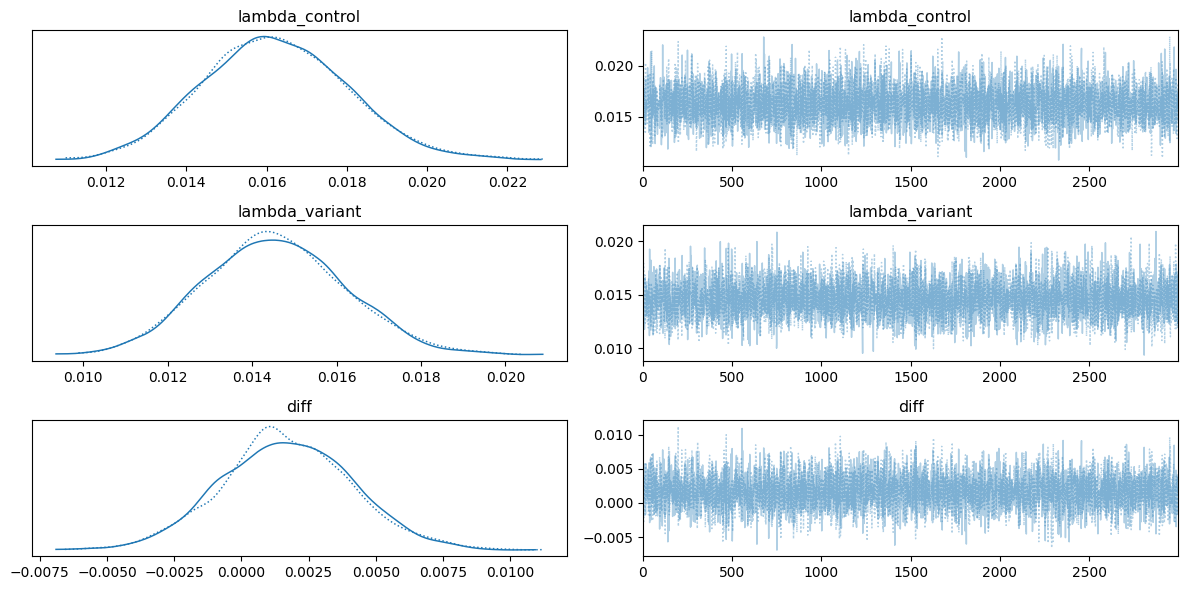

array([<Axes: title={'center': 'lambda_control'}>,
       <Axes: title={'center': 'lambda_variant'}>,
       <Axes: title={'center': 'diff'}>], dtype=object)

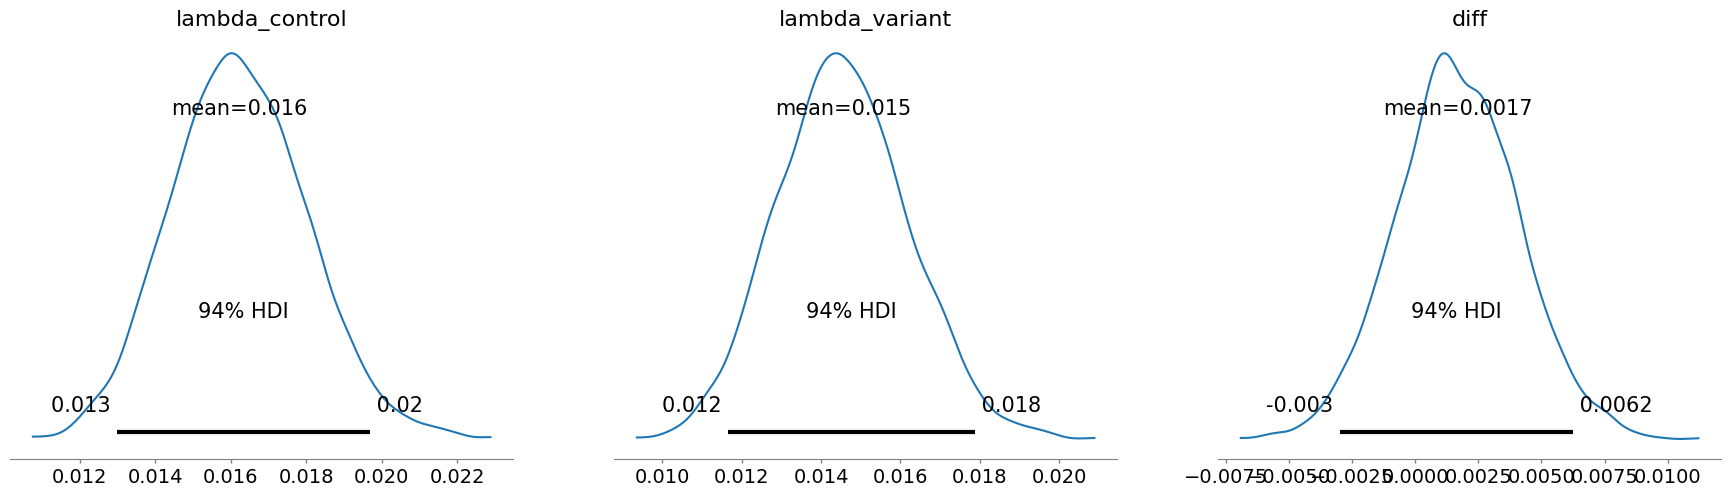

In [ ]:
# Visualise the posterior distributions and model predictions.
# This step is crucial in understanding the variability and uncertainty in our parameter estimates.
plt.figure(figsize=(12, 10))
pm.plot_trace(trace, var_names=['lambda_control', 'lambda_variant', 'diff'])

# Add the plt.tight_layout() for accessibility.
plt.tight_layout()
plt.show()

# Plot posterior distributions (includes stats summary)
az.plot_posterior(trace, var_names=['lambda_control', 'lambda_variant', 'diff'])

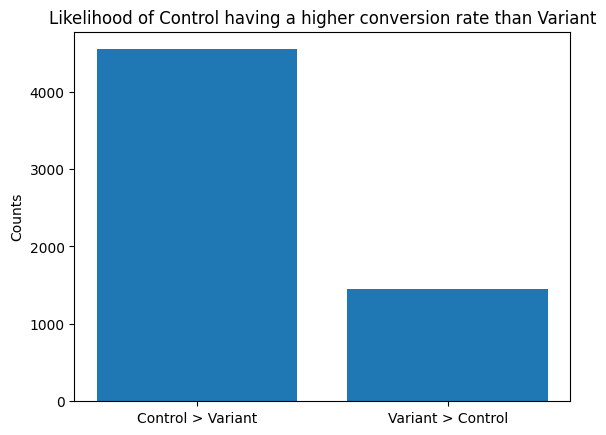

In [ ]:
# Bar plot to visualise the distribution of conversion rate
control_more_conversions = trace.posterior['control_more_conv'].values.flatten()
plt.bar(['Control > Variant', 'Variant > Control'],
        [np.sum(control_more_conversions), len(control_more_conversions) - np.sum(control_more_conversions)])
plt.title('Likelihood of Control having a higher conversion rate than Variant')
plt.ylabel('Counts')
plt.show()



# 4.0 Results and Discussion

- The Bayesian analysis suggests that the control campaign has a higher likelihood of achieving a greater number of conversions compared to the variant campaign.
- The posterior distributions for the conversion rates (lambda_control and lambda_variant) showed that the control had a consistently higher conversion rate, albeit by a small margin.
- The probability that the control campaign's conversion rate exceeded that of the variant was approximately 75%, indicating a substantial likelihood of superior performance despite the closeness of conversion rates.
